In [1]:
import IPythonImporter
import GameFramework as gf

import copy
import random
import numpy as np

importing Jupyter notebook from GameFramework.ipynb


# SimpleReverseAuction
- **parallele Rückwärtsauktionen**: für jeden SkillRequest ($n$ Einheiten eines Skills werden gesucht von Baustelle $s$) gibt es eine Auktion
- **rundenbasiert**: Ein Agent $a$ kann in einer Runde bei jeder Auktion $A$ *ein* verdecktes Gebot abgeben.

In [2]:
class Bid:
    
    def __init__(self, agent, price):
        self.agent = agent
        self.price = price
    
    def getAgent(self):
        return self.agent
    
    def getPrice(self):
        return self.price


class Auction:
    
    def __init__(self, scenario, site, request, maxBid):
        self.scenario = scenario
        self.site = site
        self.request = request
        self.maxBid = maxBid
        self.bids = list()
        self.running = True
        self.sale = None
        self.lastRound = None
        
    def nextRound(self):
        # Keine Gebote -> Gewinner aus vorhergehender Runde ermitteln
        if len(self.bids) == 0:
            if self.lastRound != None and len(self.lastRound.bids) != 0:
                
                # Gebote mit minimalem Gebot in der vorherigen Runde
                minBidPrice = min([bid.getPrice() for bid in self.lastRound.bids])
                minBids = [bid for bid in self.lastRound.bids \
                           if bid.getPrice() == minBidPrice]
                
                # Wenn nur ein Gebot mit minimalen Preis, dann dieses nehmen
                # -> ansonsten zufällig auswählen
                if len(minBids) == 1:
                    minBid = minBids[0]
                else:
                    minBid = random.choice(minBids)
                
                self.trySale(minBid)
            else:
                self.running = False
                self.sale = None
        
        # ein Gebot -> Auktion ist beendet
        elif len(self.bids) == 1:
            self.trySale(self.bids[0])        
                    
        # mehr als ein Gebot -> weiterverhandeln mit neuem Maximalpreis
        else:
            self.lastRound = copy.deepcopy(self)
            self.maxBid = min([bid.getPrice() for bid in self.bids])
            self.bids = list()
            
    def setBid(self, bid):
        if bid.price <= self.maxBid and self.running and self.sale == None:
            self.bids.append(bid)
    
    def trySale(self, bid):
        trySale = self.scenario.match(bid.getAgent(), self.site, self.request.skill, \
                                      self.request.amount, bid.getPrice())
        
        if trySale == True:
            self.sale = trySale
            self.running = False
            
            print "Ein neuer Verkauf: " + str(bid.getAgent()) + \
                  " verkauft " + str(self.request.amount) + " Einheiten '" + \
                  str(self.request.skill) + "' an " + str(self.site) + \
                  " für " + str(bid.getPrice()) + " Einheiten Geld."
        else:
            self.running = False
            self.sale = None

            
def simpleReverseAuction(scenario):

    for gameRound in range(100):
        # -----------------------------------------------------------------
        # Auktionen in jeder Runde neu aufstellen:
        # -> Erste Runde startet mit dem Budget per Einheit bezogen auf 
        #    alle gesuchten Skills einer Baustelle
        # -> In jeder weiteren Runde wird der niedrigste Preis der vergan-
        #    gene Runde als neuer Maximalpreis gewählt
        # -> Wird kein niedrigeres Gebot als der Maximalpreis geboten, 
        #    gewinnt das Gebot mit dem niedrigsten Gebot aus der vorher-
        #    gehenden Runde
        # -> Wird ein niedrigeres Gebot als der Maximalpreis geboten,
        #    so ist dieses Gebot der Gewinner
        # -----------------------------------------------------------------
        
        # erste Runde: initiales Aufstellen einer Auktion je ausgeschriebenem
        # Skilltyp von jeder Baustelle. Initiales maximales Gebot ist definiert
        # als (Budget(Baustelle)/#Skills(Baustelle))*#Skills(Baustelle, Skilltyp)
        if gameRound == 0:
            auctions = list()
            for site in scenario.sites:
                budgetPU = site.bud/np.sum(site.demand[:, 2])
                for req in site.requests:
                    auctions.append(Auction(scenario, site, req, int(req.amount*budgetPU)))
        else:
            [auction.nextRound() for auction in auctions if auction.running]

        
        # -------------------------------------------------------------------
        # Agenten reagieren mit Geboten auf die Auktionen:
        # -> Iterieren über alle Auktionen für jeden Agenten
        # -> Hat dieser Agent genug Einheiten von einem Skill und sein Preis
        #    ist im Budget der Baustelle für diesen Skill, bietet der Agent 
        #    90% vom Maximalpreis der Auktion
        # -------------------------------------------------------------------       
        for agent in scenario.agents:
            for auction in [auction for auction in auctions if auction.running]:
                agentCosts = agent.getCosts(str(auction.request.skill), auction.request.amount, \
                                            scenario.distance(auction.site, agent))
                    
                # Biete 90% vom maxBid
                if agentCosts != None and agentCosts < int((auction.maxBid - auction.maxBid/10)):   
                    auction.setBid(Bid(agent, int(auction.maxBid - auction.maxBid)))

### Beispiel
Wir lassen den Mechanismus auf unser Standardszenario los und lassen uns nach jedem Match die schriftlichen Beschreibung des Spiels und den bipartiten Graphen ausgeben. Im Anschluss lassen wir uns Grafiken zu Auswertung des Spielverlaufes anzeigen.

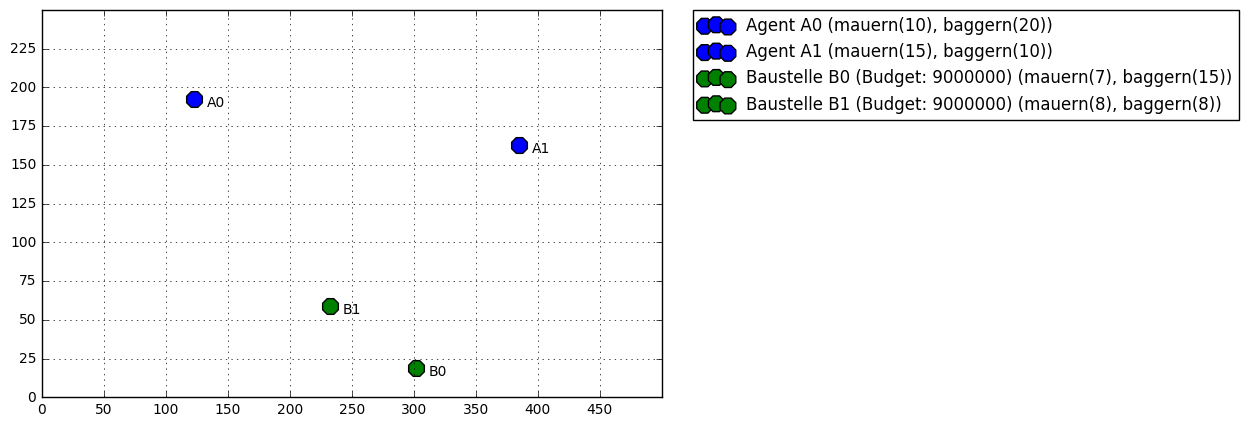

Ein neuer Verkauf: Agent A1 (mauern(8), baggern(10)) verkauft 7 Einheiten 'mauern' an Baustelle B0 (Budget: 8952966) (mauern(0), baggern(15)) für 47034 Einheiten Geld.
Ein neuer Verkauf: Agent A0 (mauern(10), baggern(12)) verkauft 8 Einheiten 'baggern' an Baustelle B1 (Budget: 8956356) (mauern(8), baggern(0)) für 43644 Einheiten Geld.
Ein neuer Verkauf: Agent A0 (mauern(2), baggern(12)) verkauft 8 Einheiten 'mauern' an Baustelle B1 (Budget: 8921004) (mauern(0), baggern(0)) für 35352 Einheiten Geld.


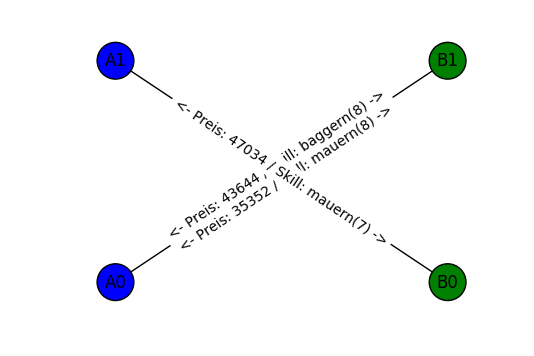

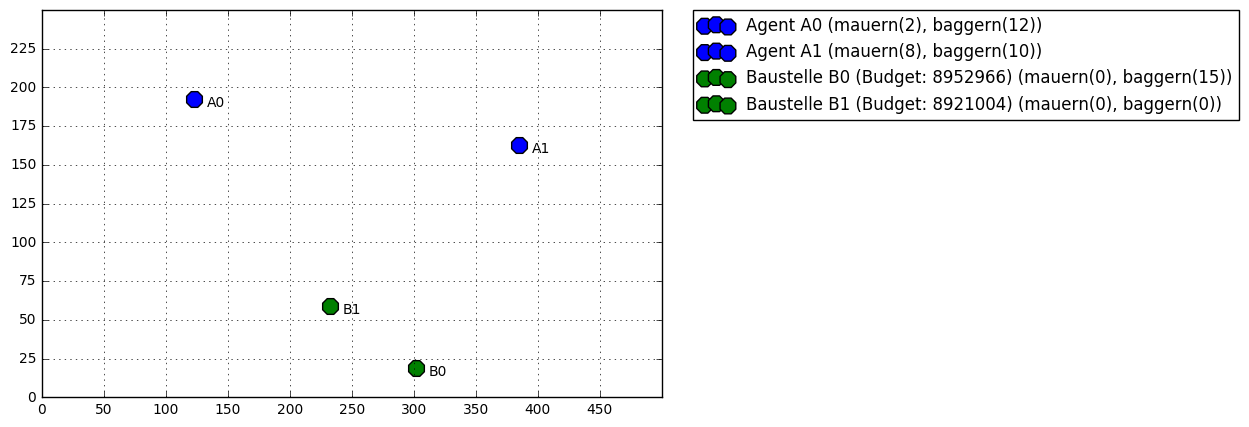

In [3]:
revScenario = gf.Scenario()
revScenario.plotMap()
simpleReverseAuction(revScenario)
revScenario.plotBiGraph()
revScenario.plotMap()

# Analyse

In [4]:
for sc in gf.generateScenaries(agentsNumber=2, sitesNumber=3, skillsNumber=2, \
                               capacitiesNumber=(5,), requestsNumber=(3,)):
    simpleReverseAuction(sc)
    print sc.getStats().values()

Ein neuer Verkauf: Agent A2 (Skill 0(2)) verkauft 3 Einheiten 'Skill 0' an Baustelle B3 (Budget: 460113) (Skill 0(0)) für 39887 Einheiten Geld.
['39887']
[['A2' 'B3' 'Skill 0' '3' '39887' '25499']]
[25499, 39887, 14388, 9, 3, 0, 0]
[0, 0, 0, 9, 3, 3, 1]
[0, 0, 0, 12, 3, 3, 1]
[0, 0, 0, 9, 3, 3, 1]
[0, 0, 0, 9, 3, 6, 2]
[0, 0, 0, 12, 3, 6, 2]
[0, 0, 0, 12, 3, 3, 1]
[0, 0, 0, 12, 3, 6, 2]
[0, 0, 0, 15, 3, 6, 2]
[0, 0, 0, 9, 3, 3, 1]
[0, 0, 0, 9, 3, 6, 2]
[0, 0, 0, 12, 3, 6, 2]
[0, 0, 0, 9, 3, 6, 2]
[0, 0, 0, 9, 3, 9, 3]
[0, 0, 0, 12, 3, 9, 3]
[0, 0, 0, 12, 3, 6, 2]
[0, 0, 0, 12, 3, 9, 3]
[0, 0, 0, 15, 3, 9, 3]
[0, 0, 0, 12, 3, 3, 1]
[0, 0, 0, 12, 3, 6, 2]
[0, 0, 0, 15, 3, 6, 2]
[0, 0, 0, 12, 3, 6, 2]
[0, 0, 0, 12, 3, 9, 3]
[0, 0, 0, 15, 3, 9, 3]
[0, 0, 0, 15, 3, 6, 2]
[0, 0, 0, 15, 3, 9, 3]
[0, 0, 0, 18, 3, 9, 3]
[0, 0, 0, 9, 3, 0, 0]
Ein neuer Verkauf: Agent A5 (Skill 1(2)) verkauft 3 Einheiten 'Skill 1' an Baustelle B7 (Budget: 50001) (Skill 1(0)) für 449999 Einheiten Geld.
['449999']
